In [1]:
import torch
from torch import nn

import torch.functional as F
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as checkpoint

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import sys

sys.path.append("../includes")

import models
import utils

from PIL import Image

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Load images

1f41b
1f98b


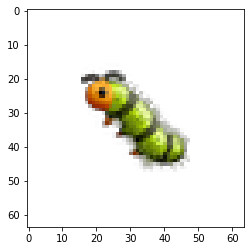

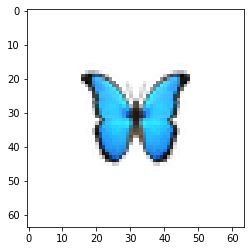

In [2]:
image_1 = utils.load_emoji("🐛", 32, 16).to(device)
image_2 = utils.load_emoji("🦋", 32, 16).to(device)

plt.imshow(image_1.transpose(0, 2).cpu())
plt.show()
plt.imshow(image_2.transpose(0, 2).cpu())
plt.show()

img_size = 64

# Initialize model

In [3]:
n_channels = 16
n_epochs = 10000
lr = 0.001
pool_size = 1024
batch_size = 16
hidden_size = 64

images = torch.stack([image_1, image_2])

model = models.Automata((64, 64), n_channels, hidden_size, device).to(device)

# Initialize pool

In [4]:
# initialize pool with seeds
seed = torch.zeros(n_channels, img_size, img_size).to(device)
seed[3:, 32, 32] = 1

pool_initials = seed[None, :].repeat(pool_size, 1, 1, 1)
pool_targets = image_1[None, :].repeat(pool_size, 1, 1, 1)

pool_target_ids = torch.zeros(pool_size).long()
# 0 for image_1, 1 for image_2

# Train model

In [5]:
losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):

    iterations = 100

    pool_indices = torch.Tensor(random.sample(
        range(pool_size), batch_size)).long()

    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states, iterations)

    phenotypes = out[:, :4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)

    per_sample_loss = loss.mean((1, 2, 3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()

    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()

    # get indices of min- and max-loss samples
    min_loss_indices = ranked_loss[:-batch_size//8]
    max_loss_indices = ranked_loss[-batch_size//8:]

    replacements = out.detach()
    replacements[max_loss_indices] = seed.clone()

    # high-loss outputs are re-tasked with
    # mapping the seed to the first image,

    # low-loss outputs are tasked with mapping
    # mapping to the other image
    pool_target_ids[pool_indices[max_loss_indices]] = 0
    pool_target_ids[pool_indices[min_loss_indices]] = 1 - \
        pool_target_ids[pool_indices[min_loss_indices]]

    pool_targets[pool_indices[max_loss_indices]] = images[0]
    pool_targets[pool_indices[min_loss_indices]
                 ] = images[pool_target_ids[pool_indices[min_loss_indices]]]

    pool_initials[pool_indices] = replacements

    if i % 100 == 0:

        print(i, np.log10(float(total_loss.cpu().detach())))

        torch.save(model.state_dict(), "../models/metamorphosis_"+str(i))

    losses.append(float(total_loss))

0 -1.4396979139287058
100 -1.4851595659457102
200 -1.5647921140420185
300 -1.6790891511759751
400 -1.6408797570143567
500 -1.6615774935080498
600 -1.5830846591031622
700 -1.6026732031569764
800 -1.6549002877300263
900 -1.6064882439510124
1000 -1.6149481904375977
1100 -1.5808418624095693
1200 -1.6435909295603957
1300 -1.6335861483284246
1400 -1.6692096492093795
1500 -1.8096823742128487
1600 -1.9434638961500421
1700 -1.884241760214729
1800 -2.245216406906859
1900 -2.2452206751999433
2000 -2.230852616184172
2100 -2.2552795202573788
2200 -2.336257209219039
2300 -2.429136494417747
2400 -2.4177166195000956
2500 -2.4890469070489534
2600 -2.51045262815839
2700 -2.4985304132556463
2800 -2.532118224341561
2900 -2.630577052053081
3000 -2.5691065986421364
3100 -2.573721244387139
3200 -2.6437714553844964
3300 -2.6282105098508706
3400 -2.659981957530834
3500 -2.6644555720803513
3600 -2.6878653637471235
3700 -2.692188452552634
3800 -2.695908007546095
3900 -2.639566312751503
4000 -2.5453864152573016
4

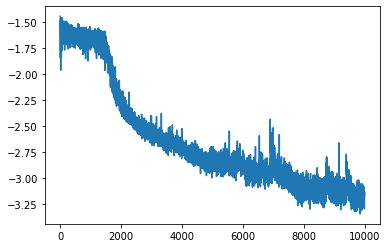

In [6]:
plt.plot(np.log10(losses))

# Load model checkpoint

In [7]:
model.load_state_dict(
    torch.load("../models/metamorphosis_9900", map_location=torch.device("cpu"))
)

<All keys matched successfully>

# Make videos

In [8]:
video = utils.get_model_history(model, seed, 1000)
utils.channels_to_gif("../videos/metamorphosis_channels.gif", video)
utils.colors_to_gif("../videos/metamorphosis_colors.gif", video)

/home/khu/.cache/pypoetry/virtualenvs/neural-automata-mPApKxAd-py3.7/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
